In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import argparse
import h5py
from scipy.stats import t as student_t
from statsmodels.stats import multitest as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# IDP_df = pd.read_pickle('male_IDP_prototype.pkl')
# vars_df = pd.read_pickle('male_vars_prototype.pkl')

IDP_df = pd.read_pickle('male_subject_direction_ICA_deltas_IDP_STEVEnorm_deconf.pkl')
vars_df = pd.read_pickle('male_subject_direction_ICA_deltas_nIDP_STEVEnorm_deconf.pkl')

# IDP_names = np.loadtxt("IDP_names.txt", dtype=str, delimiter='\n')
with open('IDP_names.txt') as f:
    IDP_names = f.readlines()
    IDP_names = [l.strip('\n\r') for l in IDP_names]
    IDP_names = np.array(IDP_names)

# IDP_categories = np.loadtxt("IDP_categories.txt", dtype=str, delimiter='\n')
with open('IDP_categories.txt') as f:
    IDP_categories = f.readlines()
    IDP_categories = [l.strip('\n\r') for l in IDP_categories]
    IDP_categories = np.array(IDP_categories)


with open('varsHeader.txt') as f:
    varsHeader = f.readlines()
    varsHeader = [l.strip('\n\r') for l in varsHeader]
    varsHeader = np.array(varsHeader)
# vars_categories = np.loadtxt("vars_categories.txt", dtype=str, delimiter='\n')
with open('vars_categories.txt') as f:
    vars_categories = f.readlines()
    vars_categories = [l.strip('\n\r') for l in vars_categories]
    vars_categories = np.array(vars_categories)

In [3]:
vars_df.head()

,modality,bonf,fdr,dataframe
0,IC = 0,5.508233,3.454135,idx ...
1,IC = 1,5.508233,3.465645,idx ...


In [4]:
vars_df.iloc[0].dataframe.head()

,idx,names,Categories,pearson_r,t_test_statistic,p_values_corrected,p_values,abs_pearson_r,log_p_values,log_p_values_corrected
0,0,Ethnic background (0.0),Ethnic Background,0.022909,1.511375,0.838967,0.130766,0.022909,0.883507,0.076255
1,1,Ethnic background (1.0),Ethnic Background,0.055081,1.517769,0.838620,0.129490,0.055081,0.887763,0.076435
2,2,Ethnic background (2.0),Ethnic Background,-0.026789,0.973647,0.978541,0.330410,0.026789,0.480947,0.009421
3,3,Genotype measurement batch (0.0),Genetic Markers,0.014719,0.962168,0.980593,0.336020,0.014719,0.473635,0.008511
4,4,Heterozygosity (0.0),Genetic Markers,-0.008991,0.587682,1.000000,0.556777,0.008991,0.254319,-0.000000


In [5]:
vars_over_bThr_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars_over_bThr_list.append(var)

In [6]:
print("Number of unique vars across all modalities: ", len(set(vars_over_bThr_list)))

Number of unique vars across all modalities:  85


In [7]:
unique_vars_over_bTHr = list(set(vars_over_bThr_list))

In [8]:
unique_vars_over_bThr_categories = []

for var in unique_vars_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_bThr_categories.append(category)

In [9]:
sorted(unique_vars_over_bTHr)

['Age first had sexual intercourse (0.0)',
 'Alcohol (1.0)',
 'Alcohol (2.0)',
 'Alcohol intake frequency. (0.0)',
 'Alcohol intake frequency. (2.0)',
 'Arms BMC (bone mineral content) (2.0)',
 'Arms BMD (bone mineral density) (2.0)',
 'Central systolic blood pressure during PWA (2.0)',
 'Current tobacco smoking (0.0)',
 'Diabetes diagnosed by doctor (0.0)',
 'Diabetes diagnosed by doctor (2.0)',
 'Diagnoses - ICD10 (G35 - G35 Multiple sclerosis)',
 'Diagnoses - ICD10 (I10 - I10 Essential (primary) hypertension)',
 'Diagnoses - ICD10 (Z864 - Z86.4 Personal history of psychoactive substance abuse)',
 'Diagnoses - secondary ICD10 (I10 - I10 Essential (primary) hypertension)',
 'Diagnoses - secondary ICD10 (Z864 - Z86.4 Personal history of psychoactive substance abuse)',
 'Femur neck BMD (bone mineral density) (left) (2.0)',
 'Femur neck BMD (bone mineral density) (right) (2.0)',
 'Femur neck BMD (bone mineral density) T-score (left) (2.0)',
 'Femur neck BMD (bone mineral density) T-score

In [10]:
modalities = []
pearson_rs_list = []
for var in unique_vars_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        bThr = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)

In [11]:
len(modalities)

85

In [12]:
df_vars_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars_over_bTHr,
    'Categories': unique_vars_over_bThr_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})

In [13]:
df_vars_over_bThr.head()

,names,Categories,modalities,pearson_r
0,L1-L4 area (2.0),Skeletal Measurements,[IC = 1],[0.08674455289088273]
1,"Non-cancer illness code, self-reported (1220 -...",Medical History,[IC = 0],[-0.07241555755140472]
2,Treatment/medication code (1140860806 - ramipril),Medical History,[IC = 0],[-0.07284010611495152]
3,Pack years adult smoking as proportion of life...,Tobacco,[IC = 0],[-0.1399297149306413]
4,Number of treatments/medications taken (2.0),Medical History,[IC = 0],[-0.09164896566619522]


In [14]:
set(df_vars_over_bThr.Categories.to_list())

{'Alcohol',
 'Blood Assays',
 'Cardiac & Circulartory Measurements',
 'Diet',
 'Lifestyle',
 'Medical History',
 'Physical Measurements',
 'Skeletal Measurements',
 'Tobacco'}

In [15]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        for i, mod in enumerate(mods[0]):
            print('   -> {} ({:.3f})'.format(mod, prs[0][i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.073)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.074)


Category: Blood Assays
------------------------------------------------
Var: Gamma glutamyltransferase (0.0)
   Modalities:
   -> IC = 1 (-0.077)
Var: IGF-1 (0.0)
   Modalities:
   -> IC = 0 (0.088)
Var: Mean corpuscular haemoglobin (0.0)
   Modalities:
   -> IC = 0 (-0.074)
Var: Mean corpuscular volume (0.0)
   Modalities:
   -> IC = 0 (-0.078)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.075)
Var: Systolic blood pressure, automated reading (0.0)
   Modalities:
   -> IC = 0 (-0.091)
Var: Systolic blood pressure, automated reading (0.1)
   Modalities:
   -> IC = 0 (-0.096)
Var: Systolic brachial blood pressure (2.0)
   Modalities:
   -> 

In [16]:
sorted(prs[0], reverse=True)

[-0.08012574973746682]

In [17]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.073)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.074)


Category: Blood Assays
------------------------------------------------
Var: Gamma glutamyltransferase (0.0)
   Modalities:
   -> IC = 1 (-0.077)
Var: IGF-1 (0.0)
   Modalities:
   -> IC = 0 (0.088)
Var: Mean corpuscular haemoglobin (0.0)
   Modalities:
   -> IC = 0 (-0.074)
Var: Mean corpuscular volume (0.0)
   Modalities:
   -> IC = 0 (-0.078)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.075)
Var: Systolic blood pressure, automated reading (0.0)
   Modalities:
   -> IC = 0 (-0.091)
Var: Systolic blood pressure, automated reading (0.1)
   Modalities:
   -> IC = 0 (-0.096)
Var: Systolic brachial blood pressure (2.0)
   Modalities:
   -> 

In [18]:
variance_threshold = 0.1

for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        if prs[0] >= variance_threshold:
            print('Var: {}'.format(name))
            print('   Modalities:')
            for i, mod in enumerate(mods):
                if prs[i] >= variance_threshold:
                    print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
    print('\n')

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Lifestyle
------------------------------------------------


Category: Medical History
------------------------------------------------


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------
Var: Arms BMC (bone mineral content) (2.0)
   Modalities:
   -> IC = 1 (0.104)
Var: Femur wards BMD (bone mineral density) (left) (2.0)
   Modalities:
   -> IC = 1 (0.103)
Var: Femur wards BMD (bone mineral density) (right) (2.0)
   Modalities:
   -> IC = 1 (0.106)
Var: Femur wards BMD (bone mineral density) T-score (left) (2.0)
   Modalities:
   -> IC = 1 (0.105)
Var: Femur ward

In [19]:
mods

('IC = 0',)

In [20]:
counter = 0
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()[0]
        if 'ElasticNetFull' in mods or 'ElasticNetFull' in mods or 'ElasticNetFull' in mods:
            print('Var: {}'.format(name))
            counter += 1
        else:
            pass
    print('\n')
    
print("There are {} vars independent from the conventional modalities".format(counter))

Category: Alcohol
------------------------------------------------


Category: Blood Assays
------------------------------------------------


Category: Cardiac & Circulartory Measurements
------------------------------------------------


Category: Diet
------------------------------------------------


Category: Lifestyle
------------------------------------------------


Category: Medical History
------------------------------------------------


Category: Physical Measurements
------------------------------------------------


Category: Skeletal Measurements
------------------------------------------------


Category: Tobacco
------------------------------------------------


There are 0 vars independent from the conventional modalities


In [21]:
IDP_df0 = pd.read_pickle('male_IDP.pkl')
vars_df0 = pd.read_pickle('male_vars.pkl')

In [22]:
vars0_over_bThr_list = []

for idx in range(len(vars_df0)):
    df = vars_df0.iloc[idx].dataframe
    bThr = vars_df0.iloc[idx].bonf
    vars_over_bThr = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_bThr:
        vars0_over_bThr_list.append(var)

In [23]:
print("Number of unique vars across all modalities: ", len(set(vars0_over_bThr_list)))

Number of unique vars across all modalities:  161


In [24]:
unique_vars0_over_bTHr = list(set(vars0_over_bThr_list))
unique_vars0_over_bThr_categories = []

for var in unique_vars0_over_bTHr:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars0_over_bThr_categories.append(category)
    
modalities0 = []
pearson_rs_list0 = []
for var in unique_vars0_over_bTHr:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df0)):
        df = vars_df0.iloc[idx].dataframe
        modality = vars_df0.iloc[idx].modality
        bThr = vars_df0.iloc[idx].bonf
        df = df[df.log_p_values>=bThr].sort_values('log_p_values', ascending=False)
        vars_over_bThr = df.names.to_list()
        pearson_r_over_bThr = df.pearson_r.to_list()
        if var in vars_over_bThr:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_bThr[vars_over_bThr.index(var)])
    modalities0.append(modalities_with_var)
    pearson_rs_list0.append(pearsonRs_with_var)

In [25]:
df_vars0_over_bThr = pd.DataFrame.from_dict({
    'names': unique_vars0_over_bTHr,
    'Categories': unique_vars0_over_bThr_categories,
    'modalities': modalities0,
    'pearson_r': pearson_rs_list0
})

In [26]:
df_vars0_over_bThr[df_vars0_over_bThr.names=='Alcohol intake frequency. (2.0)']

,names,Categories,modalities,pearson_r
21,Alcohol intake frequency. (2.0),Alcohol,"[tbss_FA_s, tbss_L1_s, tbss_MO_s, tbss_OD_s, t...","[0.08105822842776622, 0.0794058855339503, 0.07..."


In [27]:
for cat in sorted(list(set(df_vars_over_bThr.Categories.to_list()))):
    print("Category: {}".format(cat))
    print('------------------------------------------------')
    names = df_vars_over_bThr[df_vars_over_bThr.Categories == cat].names.to_list()
    for name in sorted(names):
        print('Var: {}'.format(name))
        mods = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].modalities.to_list()
        prs = df_vars_over_bThr[(df_vars_over_bThr.Categories == cat) & (df_vars_over_bThr.names == name)].pearson_r.to_list()
        mods0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].modalities.to_list()
        prs0 = df_vars0_over_bThr[(df_vars0_over_bThr.Categories == cat) & (df_vars0_over_bThr.names == name)].pearson_r.to_list()
        print('   Modalities:')
        
        prs_abs = np.abs(prs).tolist()
        _, mods = zip(*sorted(zip(prs_abs[0], mods[0]), reverse=True))
        _, prs = zip(*sorted(zip(prs_abs[0], prs[0]), reverse=True))
        
        for i, mod in enumerate(mods):
            print('   -> {} ({:.3f})'.format(mod, prs[i]))
        
        
        if len(mods0) == 0:
            print('======== ATTENTION! NEW VAR ! ==========')
        else:
            prs_abs0 = np.abs(prs0).tolist()
            _, mods0 = zip(*sorted(zip(prs_abs0[0], mods0[0]), reverse=True))
            _, prs0 = zip(*sorted(zip(prs_abs0[0], prs0[0]), reverse=True))
        

#         for i, mod in enumerate(mods0):
#             print('   -> {} ({:.3f})'.format(mod, prs0[i]))
            print('   -> {} ({:.3f})'.format(mods0[0], prs0[0]))
        
    print('\n')

Category: Alcohol
------------------------------------------------
Var: Alcohol intake frequency. (0.0)
   Modalities:
   -> IC = 0 (-0.073)
   -> tbss_MD (0.094)
Var: Alcohol intake frequency. (2.0)
   Modalities:
   -> IC = 0 (-0.074)
   -> tbss_MD (0.086)


Category: Blood Assays
------------------------------------------------
Var: Gamma glutamyltransferase (0.0)
   Modalities:
   -> IC = 1 (-0.077)
   -> tbss_ISOVF (0.082)
Var: IGF-1 (0.0)
   Modalities:
   -> IC = 0 (0.088)
   -> tbss_FA (-0.094)
Var: Mean corpuscular haemoglobin (0.0)
   Modalities:
   -> IC = 0 (-0.074)
   -> tbss_MD (0.097)
Var: Mean corpuscular volume (0.0)
   Modalities:
   -> IC = 0 (-0.078)
   -> tbss_MD (0.099)


Category: Cardiac & Circulartory Measurements
------------------------------------------------
Var: Central systolic blood pressure during PWA (2.0)
   Modalities:
   -> IC = 0 (-0.075)
   -> T2_lesions (0.111)
Var: Systolic blood pressure, automated reading (0.0)
   Modalities:
   -> IC = 0 (-0.

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Alcohol'),
  Text(1, 0, 'Blood Assays'),
  Text(2, 0, 'Cardiac & Circulartory Measurements'),
  Text(3, 0, 'Diet'),
  Text(4, 0, 'Lifestyle'),
  Text(5, 0, 'Medical History'),
  Text(6, 0, 'Physical Measurements'),
  Text(7, 0, 'Skeletal Measurements'),
  Text(8, 0, 'Tobacco')])

<Figure size 1600x960 with 0 Axes>

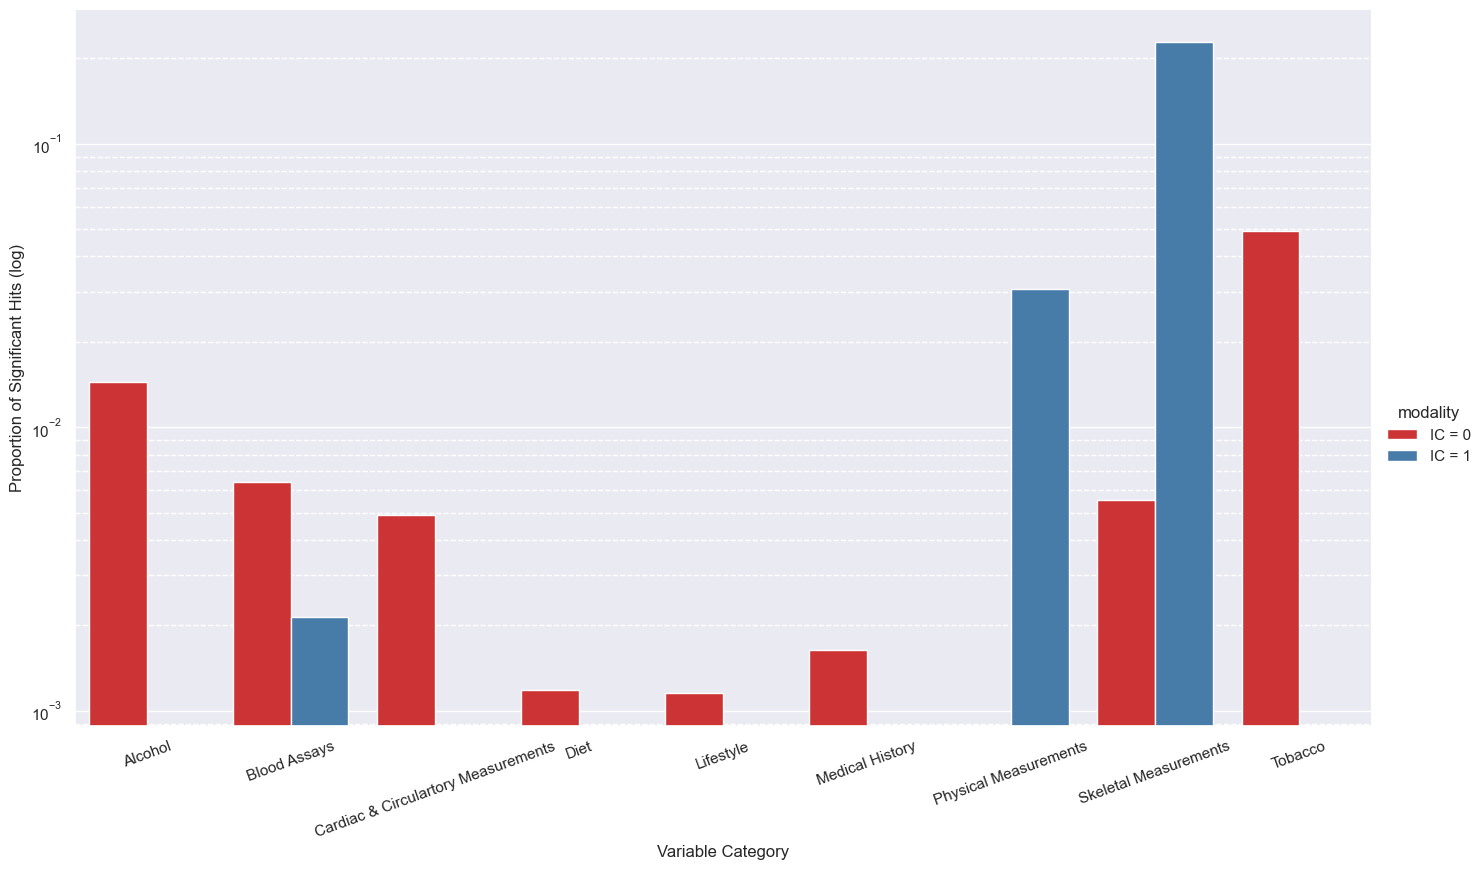

In [28]:
unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_bThr.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])

modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    bThr = vars_df.iloc[idx].bonf

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=bThr)]))
    
    modalities.append(modality)
    counters.append(counter)
    
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")

plt.figure(figsize=(16, 9.6))
sns.factorplot(x='var_name', y='var_hits', hue='modality', data=df_dct, kind='bar', height=8, 
               aspect=1.75, log=True, palette='Set1')
plt.xlabel('Variable Category')
plt.ylabel('Proportion of Significant Hits (log)')
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=20)



In [29]:
current_mods = vars_df.modality.values
modality_names = [
    'Subject-Direction ICA Component 1',
    'Subject-Direction ICA Component 2'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1600x960 with 0 Axes>

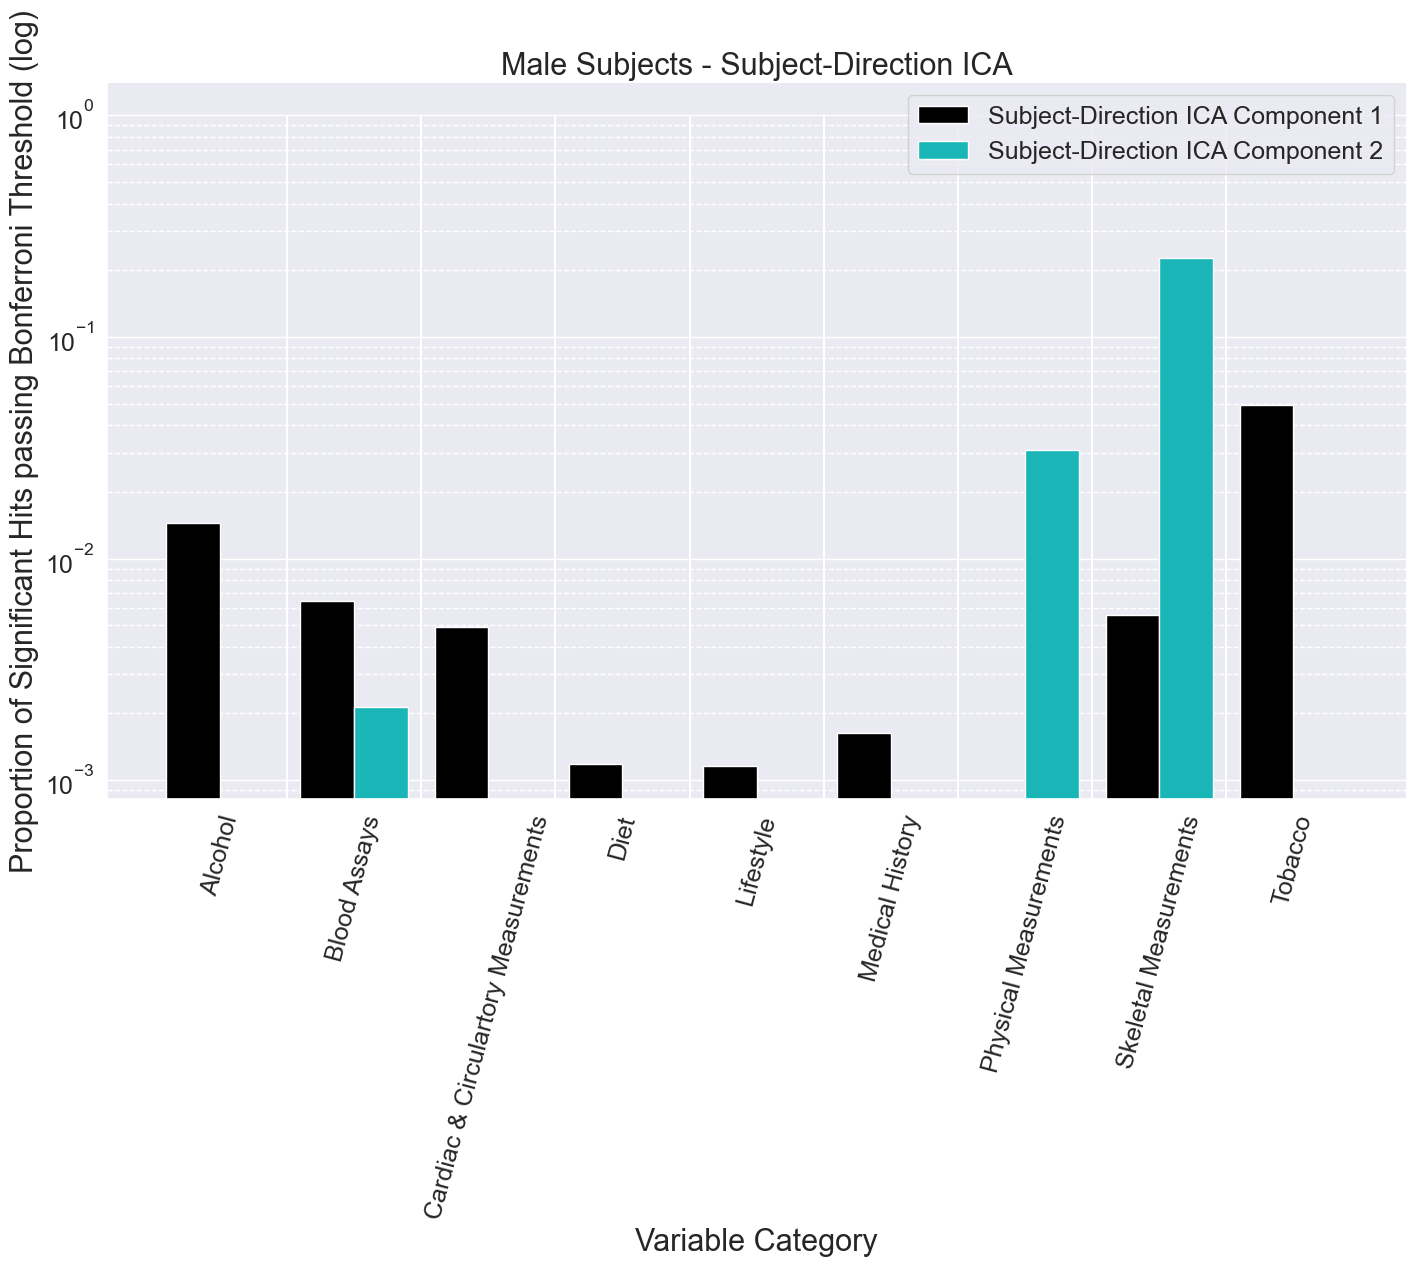

In [30]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct,
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing Bonferroni Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Male Subjects - Subject-Direction ICA', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font) #, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_proportion_significant_hits_subject_direction_ICA'+'.png', bbox_inches='tight', facecolor='white')

In [31]:
vars_over_FDR_list = []

for idx in range(len(vars_df)):
    df = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr
    vars_over_FDR = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False).names.to_list()
    for var in vars_over_FDR:
        vars_over_FDR_list.append(var)
        
print("Number of unique vars across all modalities: ", len(set(vars_over_FDR_list)))

unique_vars_over_FDR = list(set(vars_over_FDR_list))

unique_vars_over_FDR_categories = []

for var in unique_vars_over_FDR:
    idx = list(varsHeader).index(var)
    category = vars_categories[idx]
    unique_vars_over_FDR_categories.append(category)
    
modalities = []
pearson_rs_list = []
for var in unique_vars_over_FDR:
    modalities_with_var = []
    pearsonRs_with_var = []
    for idx in range(len(vars_df)):
        df = vars_df.iloc[idx].dataframe
        modality = vars_df.iloc[idx].modality
        FDR = vars_df.iloc[idx].bonf
        df = df[df.log_p_values>=FDR].sort_values('log_p_values', ascending=False)
        vars_over_FDR = df.names.to_list()
        pearson_r_over_FDR = df.pearson_r.to_list()
        if var in vars_over_FDR:
            modalities_with_var.append(modality)
            pearsonRs_with_var.append(pearson_r_over_FDR[vars_over_FDR.index(var)])
    modalities.append(modalities_with_var)
    pearson_rs_list.append(pearsonRs_with_var)
    
print(len(modalities))

df_vars_over_FDR = pd.DataFrame.from_dict({
    'names': unique_vars_over_FDR,
    'Categories': unique_vars_over_FDR_categories,
    'modalities': modalities,
    'pearson_r': pearson_rs_list
})



unique_vars_categories = list(set(vars_categories))
unique_vars_counters = []
for unique_category in unique_vars_categories:
    counter = 0
    for category in vars_categories:
        if unique_category == category:
            counter += 1
    unique_vars_counters.append(counter)
categories_of_interest = list(set(df_vars_over_FDR.Categories.to_list()))
categories_of_interest.sort()

counters_of_interest = []
for cat in categories_of_interest:
    idx = unique_vars_categories.index(cat)
    counters_of_interest.append(unique_vars_counters[idx])

modalities = []
counters = []


for idx in range(len(vars_df.modality)):
    
    modality = vars_df.iloc[idx].modality

    df_of_interest = vars_df.iloc[idx].dataframe
    FDR = vars_df.iloc[idx].fdr

    counter = []

    for category in categories_of_interest:
        counter.append(len(df_of_interest[(df_of_interest.Categories==category) & (df_of_interest.log_p_values>=FDR)]))
    
    modalities.append(modality)
    counters.append(counter)
    
unique_vars_categories2, unique_vars_counters2 = zip(*sorted(zip(unique_vars_categories, unique_vars_counters)))

counters = np.array(counters)
dct = {}
dct['modality'] = modalities
for idx, cat in enumerate(categories_of_interest):
    dct[cat] = counters[:, idx] / counters_of_interest[idx]
    
df_dct = pd.DataFrame.from_dict(dct)
df_dct.replace([np.inf, -np.inf], np.nan, inplace=True)

df_dct = pd.melt(df_dct, id_vars="modality", var_name="var_name", value_name="var_hits")




Number of unique vars across all modalities:  219
219


In [32]:
current_mods = vars_df.modality.values
modality_names = [
    'Subject-Direction ICA Component 1',
    'Subject-Direction ICA Component 2'
]
for idx, mod in enumerate(current_mods):
    df_dct.loc[df_dct["modality"] == mod, "modality"] = modality_names[idx]

/Users/aroibu_admin/agemapper/env/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1600x960 with 0 Axes>

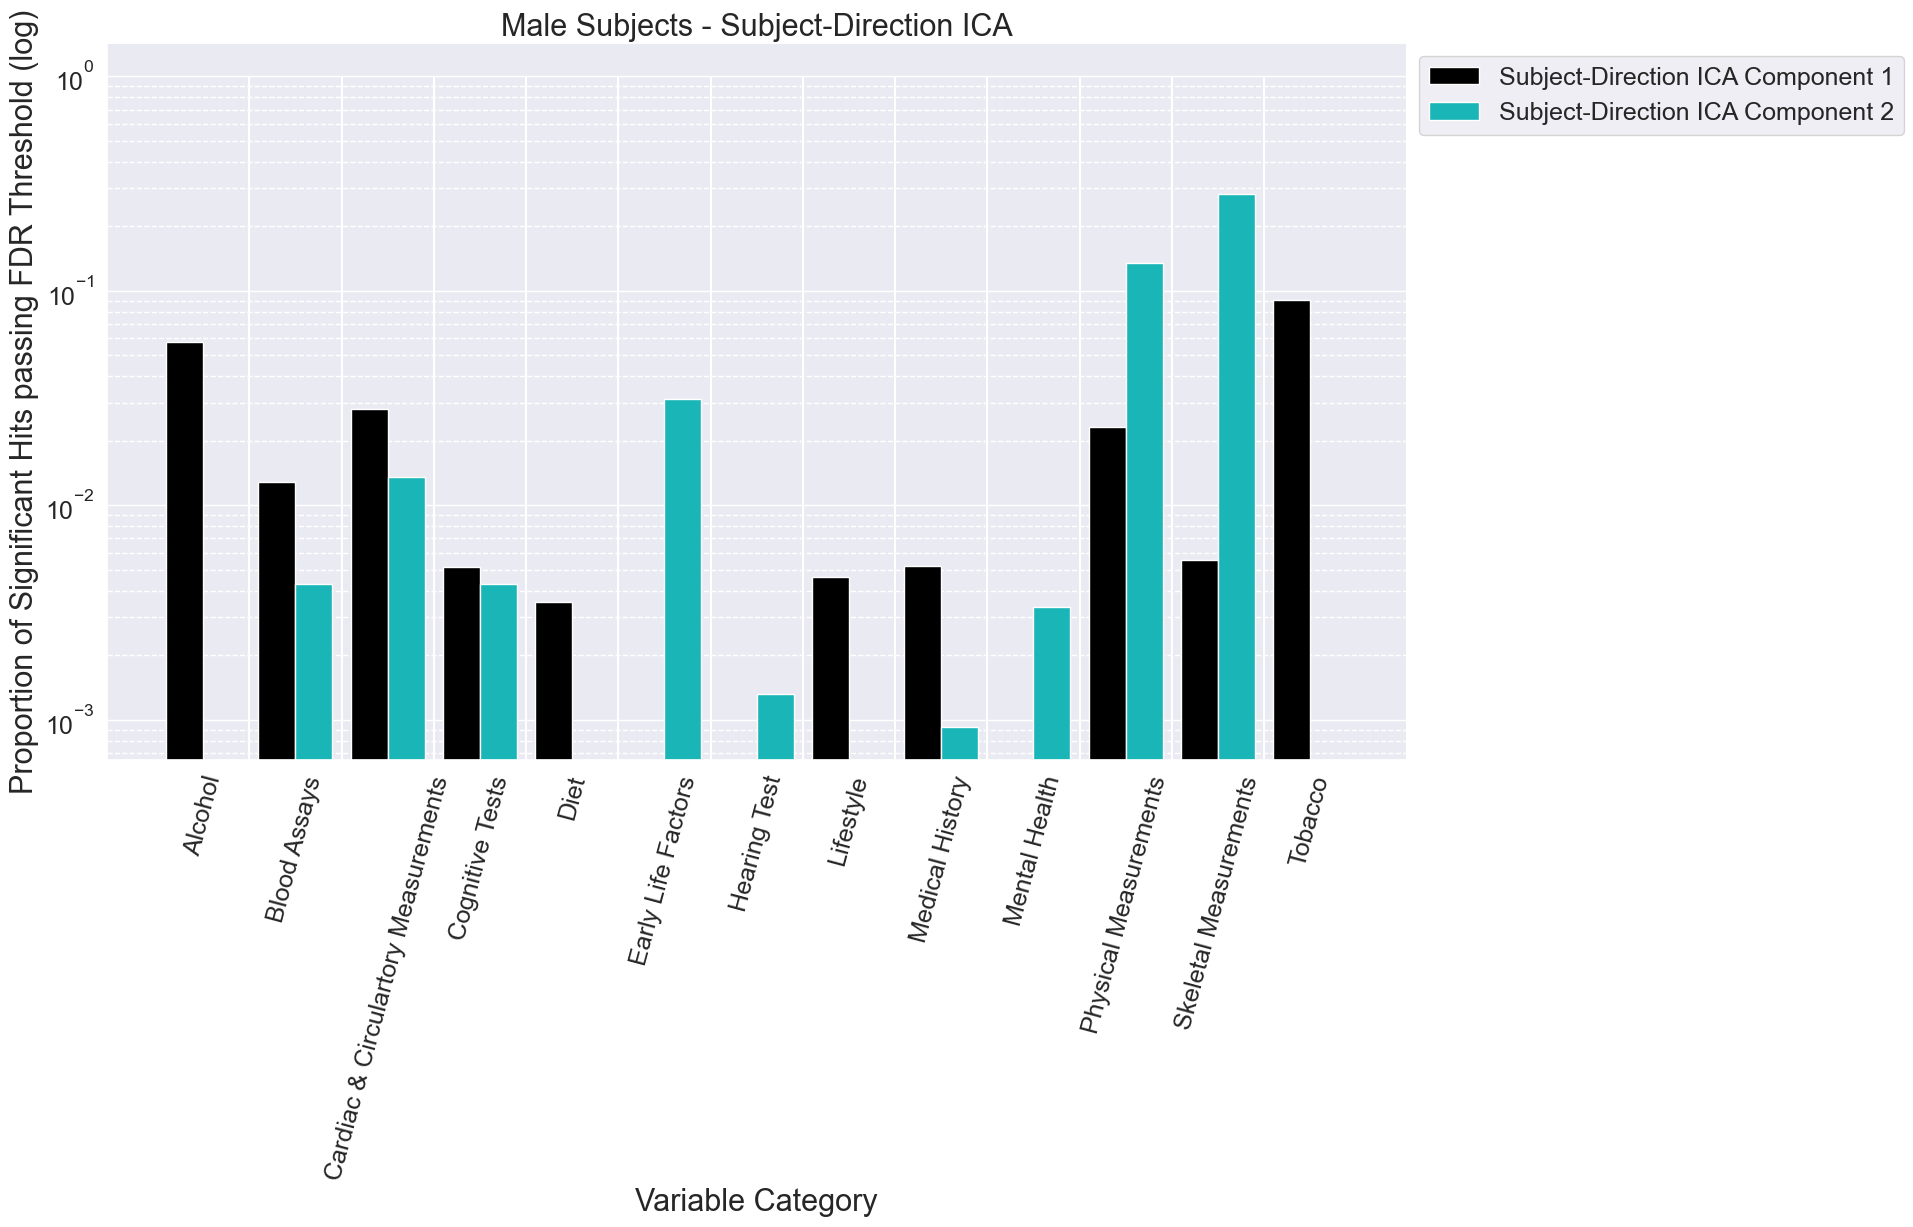

In [33]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(16, 9.6)

fig = plt.figure(figsize=figsize, facecolor='white')
# fig.patch.set_facecolor('xkcd:white')
colorCycle=['#000000', '#00CED1','#008080','#ffdf00','#9cded6',
            '#8e063b','#DAACD5','#ff7f00','#8595e1','#e31a1c',
            '#fb9a99','#0a5d00','#1fc600','#000080','#1f78b4',
            '#a6cee3', '#023fa5', '#e07b91', '#50301e']

sns.factorplot(x='var_name', y='var_hits', hue='modality', 
               data=df_dct,
               kind='bar', height=8, aspect=1.75, log=True, legend_out=False,
              palette=colorCycle)


plt.xlabel('Variable Category', fontsize=title_font_size)
plt.ylabel('Proportion of Significant Hits passing FDR Threshold (log)', fontsize=title_font_size)
plt.grid( which='minor', linestyle='--')
plt.xticks(rotation=75, fontsize= ticks_font_size)
plt.yticks(fontsize= ticks_font_size)
plt.title('Male Subjects - Subject-Direction ICA', fontsize=title_font_size)
plt.vlines(x=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5], ymin=0, ymax=1, color='white')
# plt.ylim([0, 0.05])
plt.legend(fontsize=legend_font, bbox_to_anchor=(1, 1), loc='upper left')
plt.savefig('Male_FDR_proportion_significant_hits_subject_direction_ICA'+'.png', bbox_inches='tight', facecolor='white')